In [1]:
'''
This notebook applies qiskit built-in quantum inspired classifiers to real-wold data.

Data Source:
"Car Evaluation Data Set" from https://archive.ics.uci.edu/ml/datasets/Car+Evaluation

Attribute Values:
   buying       vhigh, high, med, low
   maint        vhigh, high, med, low
   doors        2, 3, 4, 5more
   persons      2, 4, more
   lug_boot     small, med, big
   safety       low, med, high

Missing Attribute Values: none

Class Distribution (number of instances per class)
   class      N          N[%]
   -----------------------------
   unacc     1210     (70.023 %) 
   acc        384     (22.222 %) 
   good        69     ( 3.993 %) 
   v-good      65     ( 3.762 %)
'''

'''
# Some epxerimental results from running this notebook on IBM Quantum Lab 
# train/test = 300/100 
# random_state=0

# feature normalize accuracy, method  
# 6       no        86.0%     SVC-linear
# 6       no        90.0%     SVC-rbf 
# 6       no        80.0%     SVC-quantum   (up to 1 minute for computing quantum kernel)
# kpca-2  no        35.0%     QVC-SPSA-2    (2 quibits, about 24 minutes on ibmq_qasm_simulator)
# kpca-3  no        42%       QVC-SPSA-3    (3 quibits, about 38 minutes on ibmq_qasm_simulator)
# 6       no        52%       QVC-SPSA-6    (6 quibits, depth=2, no difference with 3 or 4)

# 6       yes       86.0%     SVC-linear
# 6       yes       90.0%     SVC-rbf 
# 6       yes       76.0%     SVC-quantum   (interesting that normalization hurts) 

kpca: kernal PCA

'''


## experiment configuration
normalizeFeature=False
toViz=True
seed=0
feature_dimensions=6
reduced_dimensions=6
subtrainset=300 # Full data set too huge for QML
subtestset=100

In [2]:
import numpy as np
import pandas as pd

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import * #QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

# Check backends' availability
backends = IBMQ.providers()[0].backends()
print('{:<10} {:<14} {}'.format('Available', 'pending_jobs', 'name'))
for backend in backends:
    status = backend.status()
    print('{:<10} {:<14} {}'.format('True' if status.operational==1 else 'False',
                                    status.pending_jobs, backend.name()))

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Available  pending_jobs   name
True       1              ibmq_qasm_simulator
True       545            ibmq_lima
True       80             ibmq_belem
True       57             ibmq_quito
True       1              simulator_statevector
True       1              simulator_mps
True       2              simulator_extended_stabilizer
True       2              simulator_stabilizer
True       110            ibmq_manila
True       288            ibm_nairobi
True       108            ibm_oslo


In [3]:
# prepare training and test sets
from sklearn import preprocessing
import time
import random
random.seed(seed)

columns=["buying","maint","doors","persons","lug_boot","safety"] 
f1={'vhigh':0, 'high':1, 'med':2, 'low':3}
f2=f1
f3={'2':0, '3':1, '4':2, '5more':3}
f4={'2':0, '4':1, 'more':2}
f5={'small':0, 'med':1, 'big':2}
f6={'low':0, 'med':1, 'high':2}
features=[f1,f2,f3,f4,f5,f6]
l={'unacc':0, 'acc':1, 'good':2, 'vgood':3}


# load data file
df=pd.read_csv("data/dataset.car", header=0)
y=df["class"].to_numpy() 
X=np.zeros((len(df), feature_dimensions))

for i,row in df[columns].iterrows(): 
    c=[row[columns[j]] for j in range(6)]
    X[i]=[features[j][c[j]] for j in range(6)]

  
# #take random 80% for training, rest for test.
indice=np.arange(len(y))
split_idx=int(len(indice)*0.8)
random.shuffle(indice)

train_labels=y[indice[:split_idx]]
test_labels=y[indice[split_idx:]]
feature_dimensions=6

print("Multi-class classifiers with Support Vector Machine.\n")
print("Data set: Car Evaluation")
print(f"{len(indice)} input data points. Input feature dimensions {feature_dimensions}.")

# train SVCs with Linear and RBF kernels
from sklearn.svm import SVC

if normalizeFeature:
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    X_norm = pd.DataFrame(min_max_scaler.fit_transform(X))
    train_data=[X_norm.iloc[i] for i in indice[:split_idx]]
    test_data=[X_norm.iloc[i] for i in indice[split_idx:]]
else:
    train_data=[X[i] for i in indice[:split_idx]]
    test_data=[X[i] for i in indice[split_idx:]]

print(f"Normalize input feature: {normalizeFeature}\n")

print(f"Entire data set : {len(train_labels)} (training) and {len(test_labels)} (testing)")

model = SVC(kernel='linear', random_state=seed, probability=True)
model.fit(train_data, train_labels)
accuracy_linear = model.score(test_data, test_labels)
print("Linear kernel - Test accuracy = {:<4.1f}%".format(accuracy_linear*100))

model = SVC(kernel='rbf', random_state=seed, probability=True)
model.fit(train_data, train_labels)
accuracy_rbf = model.score(test_data, test_labels)
print("RBF kernel - Test accuracy = {:<4.1f}%\n".format(accuracy_rbf*100))


if subtrainset<len(train_labels):
    print(f"Take {subtrainset} (training) and {subtestset} (testing)",
          "for performance comparision with quantum inspired mothods.")

    train_data=train_data[:subtrainset]
    train_labels=train_labels[:subtrainset]
    test_data=test_data[:subtestset]
    test_labels=test_labels[:subtestset]

    model = SVC(kernel='linear', random_state=seed, probability=True)
    model.fit(train_data, train_labels)
    accuracy_linear = model.score(test_data, test_labels)
    print("Linear kernel - Test accuracy = {:<4.1f}%".format(accuracy_linear*100))

    model = SVC(kernel='rbf', random_state=seed, probability=True)
    model.fit(train_data, train_labels)
    accuracy_rbf = model.score(test_data, test_labels)
    print("RBF kernel - Test accuracy = {:<4.1f}%".format(accuracy_rbf*100))

Multi-class classifiers with Support Vector Machine.

Data set: Car Evaluation
1728 input data points. Input feature dimensions 6.
Normalize input feature: False

Entire data set : 1382 (training) and 346 (testing)
Linear kernel - Test accuracy = 83.5%
RBF kernel - Test accuracy = 96.5%

Take 300 (training) and 100 (testing) for performance comparision with quantum inspired mothods.
Linear kernel - Test accuracy = 86.0%
RBF kernel - Test accuracy = 90.0%


Normalize input feature: False

28 seconds for computing train (300) and test (100) sets' kernels .
Quantum kernel (circuit_depth=2) - Test accuracy = 80.0%


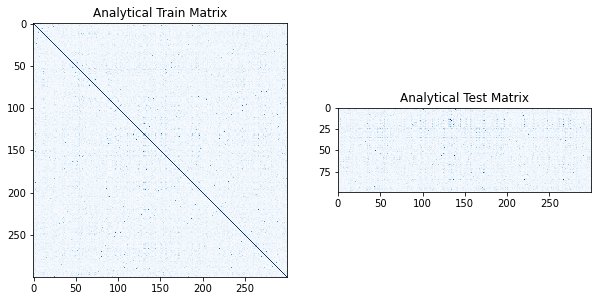

In [4]:
# Compare SVC method with with quantum kernel 
from qiskit.circuit.library import ZZFeatureMap
from qiskit import opflow

if normalizeFeature:
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,10))
    train_data=pd.DataFrame(min_max_scaler.fit_transform(train_data))
    test_data=pd.DataFrame(min_max_scaler.fit_transform(test_data))


# define quantum feature map
circuit_depth=2
my_feature_map = ZZFeatureMap(feature_dimension=feature_dimensions, reps=circuit_depth)

def calculate_kernel(feature_map, x_data, y_data=None):
    if y_data is None: y_data=x_data 
    x_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(x_data).tolist()))
        )
    y_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(y_data).tolist()))
        ) 
    kernel = np.abs(
        (~y_circuits.to_matrix_op() @ x_circuits.to_matrix_op()).eval()
    )**2
    return kernel

print(f"Normalize input feature: {normalizeFeature}\n")

# compute quantum kernel
t1=time.time()
train_kernel = calculate_kernel(my_feature_map, np.array(train_data))
test_kernel = calculate_kernel(my_feature_map,  np.array(train_data),  
                                               np.array(test_data))
t2=time.time()
print(f"{int(t2-t1)} seconds for computing train ({len(train_kernel)}) and test ({len(test_kernel)}) sets' kernels .")

# train SVC with quantum kernel
q_model = SVC(kernel='precomputed',  random_state=seed, probability=True)
q_model.fit(train_kernel, train_labels)
q_accuracy = q_model.score(test_kernel, test_labels)
print("Quantum kernel (circuit_depth={}) - Test accuracy = {:<4.1f}%".format(circuit_depth, q_accuracy*100))


# visualize computed kernels
if toViz:
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].imshow(np.asmatrix(train_kernel), interpolation='nearest',
                  origin='upper', cmap='Blues')
    axs[0].set_title("Analytical Train Matrix")
    axs[1].imshow(np.asmatrix(test_kernel), interpolation='nearest',
                  origin='upper', cmap='Blues')
    axs[1].set_title("Analytical Test Matrix")
    plt.show()

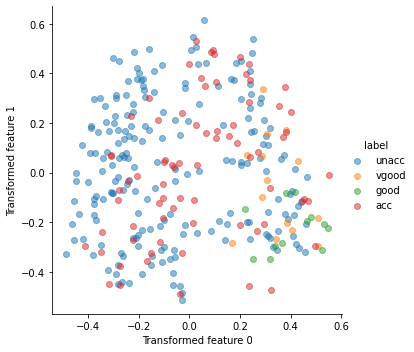

In [4]:
# The input dimension is larger than qubits available on IBMQ backend 

# dimension reduction over original data
from sklearn.decomposition import KernelPCA

if reduced_dimensions < feature_dimensions:
    pca = KernelPCA(n_components=reduced_dimensions, kernel='rbf' )
    data_reduced = pca.fit_transform(np.array(train_data + test_data))
else:
    data_reduced = np.array(train_data + test_data)

# Normalize
if normalizeFeature:
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
    data_reduced = min_max_scaler.fit_transform(data_reduced)
    
train_data_reduced = data_reduced[:subtrainset]
test_data_reduced = data_reduced[subtrainset:]

if toViz and reduced_dimensions==2:
    import matplotlib.pyplot as plt
    import seaborn as sns
    N=len(train_data) if len(train_data)<1000 else 1000
    lbl1 = f'Transformed feature 0'
    lbl2 = f'Transformed feature 1'    
    df = pd.DataFrame({lbl1: [data_reduced[i][0] for i in range(N)], 
                       lbl2: [data_reduced[i][1] for i in range(N)], 
                       'label':train_labels[:N]})
    sns.lmplot(data=df, x=lbl1, y=lbl2, fit_reg=False, hue='label', scatter_kws={'alpha':0.5})
   
else:
    print('feature_dimensions', feature_dimensions)
    print('reduced_dimensions', reduced_dimensions)

Normalize input feature: False
reduced_dimensions 6 



/tmp/ipykernel_3861/1784894689.py:48: DeprecationWarning: The quantum_instance argument is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the sampler argument.
  vqc = VQC(feature_map=FEATURE_MAP,


1966 seconds for training VQC
6 qubits | Accuracy : Test 52.0%   Train 52.0%


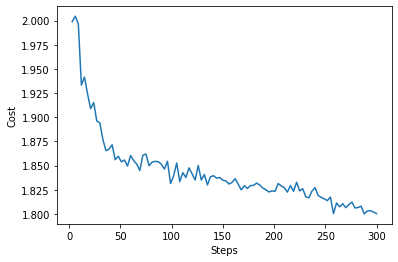

In [6]:
## Compare with QVC method
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit_machine_learning.algorithms.classifiers import VQC
from sklearn.preprocessing import OneHotEncoder
from qiskit import BasicAer
from qiskit.algorithms.optimizers import SPSA
import time

backend_name='qasm_simulator' #'ibmq_lima' 'qasm_simulator' 

# Encoding labels
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(np.array(train_labels).reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(np.array(test_labels).reshape(-1, 1)).toarray()
if len(test_labels_oh[0])!=len(train_labels_oh[1]): 
    print('Not enough samples in either train or test set')
 
else:
    #Encoding data
    FEATURE_MAP = ZZFeatureMap(feature_dimension=reduced_dimensions, reps=2)
    VAR_FORM = TwoLocal(
                    reduced_dimensions, 
                    ['ry', 'rz'], # parameterized single qubit rotations 
                    'cz',     # entangling gate
                    'full',  # entangle type: linear, full
                    reps=2,   # layers
                    insert_barriers=True
                )
    
    # Setup training log
    class Optimizerlog:
        def __init__(self):
            self.evaluations = []
            self.parameters = []
            self.costs = []

        def update(self, evaluation, parameter, cost, _stepsize, _accept):
            self.evaluations.append(evaluation)
            self.parameters.append(parameter)
            self.costs.append(cost)
    #        
    log = Optimizerlog()    

    print(f"Normalize input feature: {normalizeFeature}")
    print('reduced_dimensions', reduced_dimensions, '\n')

    # Construct VQC object
    vqc = VQC(feature_map=FEATURE_MAP,
              ansatz=VAR_FORM,
              optimizer=SPSA(callback=log.update),
              loss='cross_entropy',
              quantum_instance=BasicAer.get_backend(backend_name),    
             )

    t1=time.time()
    vqc.fit(train_data_reduced, train_labels_oh)
    print(f"{int(time.time()-t1)} seconds for training VQC")
    
    acc_train = vqc.score(train_data_reduced, train_labels_oh)
    acc_test = vqc.score(test_data_reduced, test_labels_oh)
    print("{} qubits | Accuracy : Test {:<4.1f}%   Train {:<4.1f}%".format(\
                        reduced_dimensions, acc_test*100, acc_train*100))

    # plot loss curve
    fig = plt.figure()
    plt.plot(log.evaluations, log.costs)
    plt.xlabel('Steps')
    plt.ylabel('Cost')
    plt.show('Train loss curve')